<a href="https://colab.research.google.com/github/MichaelHalaj/Data-Science-CS301/blob/main/Logistic_Regression_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
#DISCLAIMER: I tried my best and this is all I can come up with

In [2]:
from google.colab import files
files.upload()
#{'kaggle.json': b'{"username":"michaelhalaj","key":"bdb4c5734628864eae3507d48993d1f2"}'}

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michaelhalaj","key":"bdb4c5734628864eae3507d48993d1f2"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c avazu-ctr-prediction

 99% 1.18G/1.19G [00:08<00:00, 140MB/s]
100% 1.19G/1.19G [00:09<00:00, 141MB/s]


In [7]:
! unzip avazu-ctr-prediction.zip 

Archive:  avazu-ctr-prediction.zip
  inflating: sampleSubmission.gz     
  inflating: test.gz                 
  inflating: train.gz                


In [8]:
import numpy as np
import pandas as pd

rows = 10000 #chose this number because I don't have all day to load in millions of rows
unused_cols = ["hour", "device_id", "device_ip"]
label_col = "click"

df = pd.read_csv('train.gz', nrows = rows)
df = df.drop(unused_cols, axis = 1)
num_of_1s = (df[label_col] == 1).sum()
num_of_0s = (df[label_col] == 0).sum()

def weight(n_samples, n_classes, n_sample):
  return n_samples/(n_classes * n_sample)

w0 = weight(rows, 2, num_of_0s)
w1 = weight(rows, 2, num_of_1s)

df = df.apply(lambda x: pd.factorize(x)[0])#converts string variables to int values
df_label = df['click']
ys_unscaled = np.array(df.loc[:,'click']) #unscaled ys will be used for predictions

print(ys_unscaled)

df_test = pd.read_csv('test.gz', nrows = rows)



for i in df.columns: #normalizing the dataset where mean = 0 and std = 1
    df[i] = (df[i] - df[i].mean()) / df[i].std()

rowlen = df.shape[0] #size of the column

df['ones'] = np.ones((rowlen,), dtype=int) #create a row of ones as starting intercept

df_train = df.drop(label_col, axis = 1)

xs = np.array(df_train.loc[:,['ones', 'banner_pos']]) #decided to only use banner position as I didn't know what most other features were
print(xs)
ys = np.array(df.loc[:,'click']) 
print(ys)

#https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
weights = [w0, w1]
print(w0)
print(w1)


[0 0 0 ... 1 0 0]
[[ 1.         -0.48981795]
 [ 1.         -0.48981795]
 [ 1.         -0.48981795]
 ...
 [ 1.          2.02078147]
 [ 1.         -0.48981795]
 [ 1.         -0.48981795]]
[-0.45350887 -0.45350887 -0.45350887 ...  2.20480805 -0.45350887
 -0.45350887]
0.6028454304316373
2.9308323563892147


In [9]:
from typing import List

Vector = List[float] #providing a name to a list of floats for readability

epsilon = 1e-5 #this small value is used to prevent 0 from occurring in log functions, which threw off the results since log(0) is undefined

def logistic(x: float) -> float:
  """Also known as a sigmoid function, where as input get large and positive, it gets closer
  and closer to 1 and input gets large and negative, it gets closer to 0"""
  return 1.0 / (1 + np.exp(-x))


def logistic_prime(x :float) -> float:
  """Derivative of the logistic function"""
  y = logistic(x)
  return y * (1 - y)


def _negative_log_likelihood(x: Vector, y: float, beta: Vector, weight: List[float]) -> float:
  """Working with negative log likelihood, since maximizing the likelihood is the same
  as minimizing its negative; this is the negative log likelihood for one data point"""
  if y == 1:
    return -(weight[1]) * np.log(epsilon + logistic(np.dot(x, beta))) #epsilon used to prevent log(0) == undefined
  else:
    return -(weight[0]) * np.log(epsilon + 1 - logistic(np.dot(x, beta))) #epsilon used to prevent log(0) == undefined


def negative_log_likelihood(xs: List[Vector], ys: List[float], beta: Vector, weight: List[float]) -> float:
  """Sum of all individual log likelihoods within the dataset"""
  return sum(_negative_log_likelihood(x, y, beta, weight) for x,y in zip(xs, ys))


def _negative_log_partial_j(x: Vector, y: float, beta: Vector, j: int) -> float:
  """jth partial derivative for one data point"""
  return -(y - logistic(np.dot(x, beta))) * x[j]


def _negative_log_gradient(x: Vector, y: float, beta: Vector) -> Vector:
  """Gradient for one data point"""
  return [_negative_log_partial_j(x, y, beta, j) for j in range(len(beta))]


def negative_log_gradient(xs: List[Vector], ys: List[float], beta: Vector) -> Vector:
  """Vector sum of gradients for all individual data points"""
  return np.sum([_negative_log_gradient(x, y, beta) for x, y in zip(xs, ys)])


def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
  """Moves step_size, which in this case is the negative learning rate, in the
  gradient direction from v, which in this case is beta"""
  step = np.multiply(step_size, gradient)
  return np.add(v, step)


import tqdm #used to show progress of the gradient descent within epochs
import random #used to select a random number to start the gradient descent

def predict(row, coefficients):
  y_hat = coefficients[0]
  for col in range(len(row) -1):
    y_hat+=coefficients[col + 1] * row[i]
  return logistic(y_hat)

"""I have no idea how to obtain y_test from the training model, so I decided to just
split the data set into training and test rather than using the provided test set
from the competition"""

def split_data(data, prob):
 """Split data into fractions [prob, 1 - prob]"""
 data = data[:] # Make a shallow copy
 random.shuffle(data) # because shuffle modifies the list.
 cut = int(len(data) * prob) # Use prob to find a cutoff
 return data[:cut], data[cut:] # and split the shuffled list there.


def train_test_split(xs, ys, ys_unscaled, test_pct):
 # Generate the indices and split them
 idxs = [i for i in range(len(xs))]
 train_idxs, test_idxs = split_data(idxs, 1 - test_pct)
 return ([xs[i] for i in train_idxs], # x_train
 [xs[i] for i in test_idxs], # x_test
 [ys[i] for i in train_idxs], # y_train
 [ys[i] for i in test_idxs], #y_test
 [ys_unscaled[i] for i in test_idxs]) # y_test_unscaled

x_train, x_test, y_train, y_test, y_test_unscaled = train_test_split(xs, ys, ys_unscaled, 0.33)

random.seed(0)
#x_train = xs
#y_train = ys

learning_rate = 0.0001
#wj=n_samples / (n_classes * n_samplesj)

beta = [random.random() for _ in range(len(xs[0]))]
with tqdm.trange(1000) as t: #used to show progress of the function on very large datasets
  for epoch in t:
    gradient = negative_log_gradient(x_train, y_train, beta)
    beta = gradient_step(beta, gradient, -learning_rate)
    loss = negative_log_likelihood(x_train, y_train, beta, weights)
    t.set_description(f"loss: {loss:.3f} beta: {beta}")
  


loss: 304.059 beta: [-4.6348559  -4.72132335]: 100%|██████████| 1000/1000 [01:35<00:00, 10.47it/s]


In [15]:
dftest = pd.read_csv('test.gz', header = 0, skiprows=(1,100000), nrows = rows)

zeros = 0
ones = 0
for i in y_test_unscaled:
  if i == 1:
    ones+=1
  if i == 0:
    zeros+=1
print(zeros)
print(ones)

def scale(data : List[Vector]):
  return np.mean(data), np.std(data)
mean, std = scale(x_train)
"""
beta_unscaled = [(beta[0]
                  -beta[1] * mean / std),
                  beta[1] / std]

"""
print(y_test)
print(y_test_unscaled)
preds = []
prob_threshold = 0.05 #value of the probability threshold
true_positives = false_positives = true_negatives = false_negatives = 0
for x_i, y_i in zip(x_test, y_test_unscaled):
  prediction = logistic(np.dot(beta, x_i))
  preds.append(prediction)
  if y_i == 1 and prediction >= prob_threshold:
    true_positives +=1
  elif y_i == 1:
    false_negatives += 1
  elif prediction >= prob_threshold:
    false_positives += 1
  else:
    true_negatives += 1
print(preds)
print(true_positives, false_positives, true_negatives, false_negatives) 
  
  #https://www.kaggle.com/code/jejutphyunchangwoo/logisticregression-practice-0815/notebook


precision = true_positives / (true_positives + false_positives)

recall = true_positives / (true_positives + false_negatives)

"""I am getting a very low precision most likely due to the class imbalance"""
print(precision)
print(recall)

2741
560
[-0.4535088662608354, -0.4535088662608354, 2.2048080520324556, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, 2.2048080520324556, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, 2.2048080520324556, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, 2.2048080520324556, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, 2.2048080520324556, -0.4535088662608354, -0.4535088662608354, 2.2048080520324556, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.4535088662608354, -0.453508

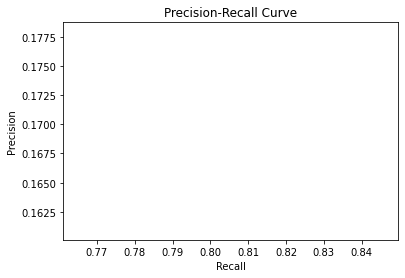

In [11]:
import matplotlib.pyplot as plt
"""The trade off between precision and recall is that as precision increases, recall decreases. 
As recall increases, precision decreases.
"""
plt.plot(recall, precision, color = 'red')

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.show()